### Необходимые библиотеки

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import learning_curve
import yfinance as yf

matplotlib.style.use('seaborn')

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

### Анализ входных данных

Цель моей курсовой работы – основываясь на исторических данных котировок акций уметь предсказывать рост или падение цены акции в разрезе 1 дня. То есть я решаю задачу классификации, где 1 – рост акции, 0 – падение акции.
Первая задача, которую я решил в своей курсовой работе – выбор набора данных и его анализ. С помощью библиотеки yfinance я могу получить котировки любой компании, акции которой торгуются на американской бирже NASDAQ. Я решил выбрать Microsoft – компанию с многолетней историей, которая является одним из мировых лидеров в области информационных технологий. С помощью библиотеки yfinance я загрузил данные за весь период торгов акций компании. Шаг датасата по таймлайну – 1 день.


In [5]:
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

In [6]:
msft_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.055380,0.063524,0.055380,0.060809,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060809,0.064067,0.060809,0.062980,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062980,0.064609,0.062980,0.064067,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.064067,0.064609,0.061894,0.062437,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.062437,0.062980,0.060809,0.061351,47894400,0.0,0.0


При анализе данных я построил график цены акции. Можно отметить, что начиная с 1986 цена акции росла достаточно медленно, однако примерно в 2015 начался крайне бурный рост. Однако в конце 2021 года началось стремительное падение, которое было связано с ухудшением ситуации на мировом рынке.

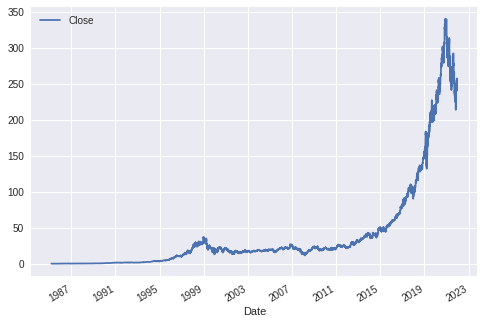

In [7]:
msft_hist.plot.line(y='Close', use_index=True)
plt.show()

Информация о датасете

In [8]:
msft_hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9270 entries, 1986-03-13 00:00:00-05:00 to 2022-12-20 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9270 non-null   float64
 1   High          9270 non-null   float64
 2   Low           9270 non-null   float64
 3   Close         9270 non-null   float64
 4   Volume        9270 non-null   int64  
 5   Dividends     9270 non-null   float64
 6   Stock Splits  9270 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 837.4 KB


### Подготовка данных

Сперва я копирую данные столбца Close в рабочий датасет data, и переименовываю его в Actual_Close, для того чтобы знать, какая реальная цена была в тот или иной день.

In [9]:
data = msft_hist[['Close']]
data = data.rename(columns={'Close': 'Actual_Close'})
data.head()

,Actual_Close
Date,
1986-03-13 00:00:00-05:00,0.060809
1986-03-14 00:00:00-05:00,0.062980
1986-03-17 00:00:00-05:00,0.064067
1986-03-18 00:00:00-05:00,0.062437
1986-03-19 00:00:00-05:00,0.061351


Далее я создаю колонку Target – которую и собираюсь предсказывать. Для этого я использую метод rolling, который агрегирует данные по текущей строке и по n-1 предыдущим строкам (n указывается как параметр метода, в моем случае n=2). Затем я применяю метод apply и lambda-функцию, с помощью которых создаю таргет (если значение предыдущего дня строго меньше значения текущего дня, то таргет равен 1).

In [10]:
data['Target'] = msft_hist['Close'].rolling(2).apply(lambda x: x.iloc[1]>x.iloc[0])
data.head()

,Actual_Close,Target
Date,,
1986-03-13 00:00:00-05:00,0.060809,NaN
1986-03-14 00:00:00-05:00,0.062980,1.0
1986-03-17 00:00:00-05:00,0.064067,1.0
1986-03-18 00:00:00-05:00,0.062437,0.0
1986-03-19 00:00:00-05:00,0.061351,0.0


После этого с помощью метода shift я сдвигаю все первоначальные данные на 1 день вперед.

In [11]:
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 00:00:00-05:00,0.055380,0.063524,0.055380,0.060809,1.031789e+09,0.0,0.0
1986-03-17 00:00:00-05:00,0.060809,0.064067,0.060809,0.062980,3.081600e+08,0.0,0.0
1986-03-18 00:00:00-05:00,0.062980,0.064609,0.062980,0.064067,1.331712e+08,0.0,0.0
1986-03-19 00:00:00-05:00,0.064067,0.064609,0.061894,0.062437,6.776640e+07,0.0,0.0


Затем с помощью метода join я создаю итоговый датасет data, в котором есть колонки:

•	Actual_Close – реальная цена акции на момент закрытия биржи

•	Target – бинарное значение, отвечающее за рост или падение акции

•	Close, Volume, Open, High, Low – атрибуты, значения которых сдвинуты на 1 день вперед


In [12]:
predictors = ["Close", "Volume", "Open", "High", "Low"]

data = data.join(msft_prev[predictors]).iloc[1:]
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062980,1.0,0.060809,1.031789e+09,0.055380,0.063524,0.055380
1986-03-17 00:00:00-05:00,0.064067,1.0,0.062980,3.081600e+08,0.060809,0.064067,0.060809
1986-03-18 00:00:00-05:00,0.062437,0.0,0.064067,1.331712e+08,0.062980,0.064609,0.062980
1986-03-19 00:00:00-05:00,0.061351,0.0,0.062437,6.776640e+07,0.064067,0.064609,0.061894
1986-03-20 00:00:00-05:00,0.059723,0.0,0.061351,4.789440e+07,0.062437,0.062980,0.060809


In [99]:
sum(data['Target']==1)/len(data['Target'])

0.4943988050784167

Произвели предобработку данных для дальнейшей работы с ними 

### Базовая модель

Далее я решил создать базовую модель, чтобы протестировать ее, оценить результаты и продумать логику своей основной модели. Важно отметить, что из-за того, что данные представляют собой временной ряд, я не могу использовать кросс-валидацию данных. Иначе я бы использовал данные из будущего для предсказания прошлого, что было бы просто некорректным. Вместо этого я в дальнейшем буду несколько раз делить данные на тест и трейн, однако в базовой модели я выделю все данные, кроме последних 100 строк для трейна, а оставшиеся 100 строк будут тестовыми данными.
Для базовой модели я выбрала алгоритм RandomForestClassifier. Данный алгоритм является представителем дерева решений – модели, принципом которой является разделение входных данных при помощи ветвления по их признакам. 


In [13]:
model = RandomForestClassifier(n_estimators=100, 
                               min_samples_split=200, 
                               max_depth=5, 
                               max_features='auto',
                               min_samples_leaf=4,
                               criterion ='gini',
                               random_state=1)

Инициализация модели

In [14]:
predictors = ["Close", "Volume", "Open", "High", "Low"]


In [15]:
X = data[predictors].values
y = data['Target'].values

In [16]:
train_sizes, train_scores, validation_scores = learning_curve(model, X, y, cv=2, scoring = None)

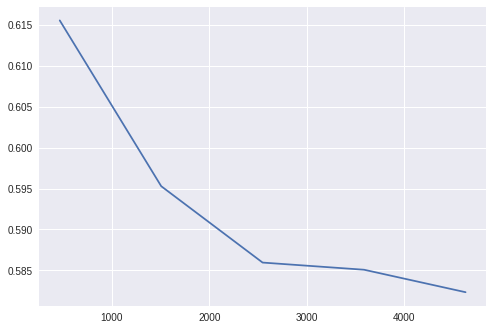

In [17]:
plt.plot(train_sizes,np.mean(train_scores,axis=1))

Разделение на тест и трейн

In [18]:
train = data.iloc[:-100]
test = data.iloc[-100:]

Далее я провел обучение модели. В качестве предикатов были выбраны столбцы Close, Volume, Open, High, Low. В качестве таргета столбец Target.

In [19]:
model.fit(train[predictors], train["Target"])

RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=200,
                       random_state=1)

Теперь мне необходимо оценить, насколько хорошо моя модель предсказывает данные. Для этого я выбрал метрику precision, которая оценивает какую долю из всех предсказанных значений я предсказал верно. Я считаю, что для выбранной мной цели использования модели машинного обучения эта метрика является самой подходящей. В предсказании цены акции лучше всего минимизировать FP, чем минимизировать FN.
 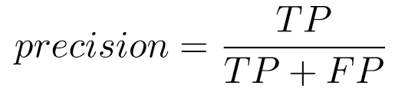


Для моей базовой модели метрика precision получилась 0.418, что меньше, чем если бы я принимал решение подбрасывая монетку. Думаю, что такое значение метрики вызвано рядом причин: 

•	для тестирования я беру всего 100 последних дней, что мало и в плане количества, и в то же время не совсем корректно с точки зрения анализа временных рядов

•	в последние 100 дней по сравнению с жизнью всей акции происходит достаточно аномальная активность, а именно падение


In [20]:
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

round(precision_score(test["Target"], preds), 3)

0.418

In [21]:
# смотрим на графике что предсказывает модель
combined = pd.DataFrame({'Target' :test["Target"], 'Predictions': preds})
combined.head()

,Target,Predictions
Date,,
2022-08-01 00:00:00-04:00,0.0,1.0
2022-08-02 00:00:00-04:00,0.0,1.0
2022-08-03 00:00:00-04:00,1.0,1.0
2022-08-04 00:00:00-04:00,1.0,1.0
2022-08-05 00:00:00-04:00,0.0,1.0


Для более глубоко понимания поведения модели я хочу посмотреть на график значений таргета и предсказанного моделью значения. 

Как можно увидеть на графике в большинстве случаев модель предпочитает предсказывать рост акции, и лишь иногда она предсказывает падение цены акции.Проблему низкой метрики я собираюсь решить за счет улучшения модели по нескольким показателям

•	увеличение количества предикатов

•	нормализация данных

•	изменение подхода в разделении данных на тест и трейн


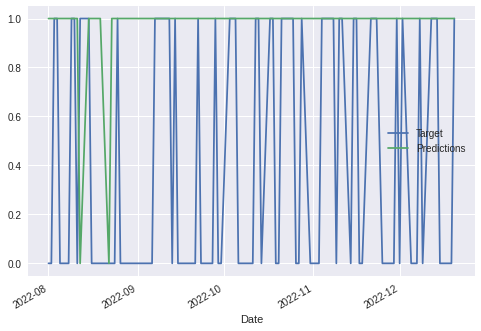

In [22]:
combined.plot()
plt.show()

In [23]:
# import graphviz
# from sklearn.tree import export_graphviz

# dot_data = export_graphviz(model.estimators_[0], 
#                            feature_names=predictors,
#                            filled=True, impurity=True, 
#                            rounded=True)

# graph = graphviz.Source(dot_data, format='png')
# graph

### Упаковка в функции

In [24]:
predictors_before = ["Close", "Volume", "Open", "High", "Low"]

Также я написал функцию, которая собирает все манипуляции с данными, которые применялись на прошлых шагах.

In [25]:
def preproc_data(msft_hist):
    data = msft_hist[['Close']]
    data = data.rename(columns={'Close': 'Actual_Close'})
    data['Target'] = msft_hist['Close'].rolling(2).apply(lambda x: x.iloc[1]>x.iloc[0])
    msft_prev = msft_hist.copy()
    msft_prev = msft_prev.shift(1)
    data = data.join(msft_prev[predictors_before]).iloc[1:]
    return data

В первую очередь я хочу нормализовать свои данные. Для этого я написал функцию, основой которой является метод минимакс. 
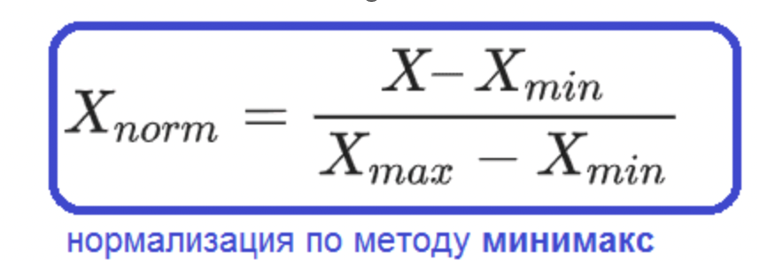

In [26]:
def normalize_data(data, predictors):
    for el in predictors:
        mins = data[el].min()
        maxs = data[el].max()
        zn = maxs-mins
        data[el] = (data[el]-mins)/zn
    return data

После этого я задумался над добавлением новых предикатов, которые бы основывались на имеющихся данных. Я буду добавлять следующие значения:

•	Среднее значение цены закрытия за неделю

•	Среднее значение цены закрытия за месяц

•	Среднее значение цены закрытия за квартал

•	Среднее значение цены закрытия за год

•	Тренд роста или падения цены за неделю

•	Тренд роста или падения цены за месяц

•	Отношение цены открытия к цене закрытия

•	Отношение максимальной цены за день к цене закрытия

•	Отношение минимальной цены за день к цене закрытия
Все эти новые предикаты я получаю на основе имеющихся данных, поэтому я завернул этот процесс в функцию rolling_means.


In [27]:
def rolling_means(data):
    weekly_mean = data.rolling(7).mean()['Close']
    monthly_mean = data.rolling(30).mean()['Close']
    quarterly_mean = data.rolling(90).mean()['Close']
    year_mean = data.rolling(365).mean()['Close']
    
    weekly_trend = data.shift(1).rolling(7).sum()["Target"]
    monthly_trend = data.shift(1).rolling(30).sum()["Target"]
    
    # means
    data['weekly_mean'] = weekly_mean
    data['monthly_mean'] = monthly_mean
    data['quarterly_mean'] = quarterly_mean
    data['year_mean'] = year_mean
    
    #trend
    data['weekly_trend'] = weekly_trend/7
    data['monthly_trend'] = monthly_trend/31
    
     # open high low ratio
    data['open_close_ratio'] = data['Open'] / 100*data['Close']
    data['high_close_ratio'] = data['High'] /100* data['Close']
    data['low_close_ratio'] = data['Low'] / 100*data['Close']

    
    return data

После этого мне понадобилась функция, которая вмещала бы в себя все предыдущие шаги обработки данных, которые должны производиться в следующем порядке:
1.	Формирование первоначального датасета со сдвигом предикатов
2.	Нормализация данных
3.	Создание новых предикатов на основе имеющихся 
4.	Очистка данных от NaN
Все эти шаги были реализованы в отдельных функциях, поэтому в функции final_data мне требовалось просто собрать все это вместе.


In [28]:
def final_data(msft_hist):    
    data = preproc_data(msft_hist)
    data = normalize_data(data, predictors_before)
    data = rolling_means(data)
    data = data.dropna(axis=0)

    return data 

После этого я хочу улучшить модель, обучая ее не только на последних 100 строках. Это даст мне более надежную оценку ошибки. Я буду использовать метод обратного тестирования, который гарантирует, что я использую данные только до того дня, когда я прогнозирую. Мой алгоритм обучается на start строках, а затем тестируется на последующих step строках.
Также с помощью параметра use_predict_proba я могу увеличивать порог уверенности предсказания роста цены до 0,65.


In [29]:
def backtest(data, model, predictors, start = 700, step = 350, use_predict_proba=True):
  predictions = []

  for i in range(start, data.shape[0], step):
      # Split into test and train
      train = data.iloc[0:i].copy()
      test = data.iloc[i:(i+step)].copy()

      # Fit model
      model.fit(train[predictors], train['Target'])

      # Make predictors
      if use_predict_proba:
          preds = model.predict_proba(test[predictors])[:, 1]
          preds = pd.Series(preds, index = test.index)
          preds[preds>0.65] = 1
          preds[preds<=0.65] = 0
      else:
          preds = model.predict(test[predictors])
          preds = pd.Series(preds, index = test.index)

       # Combine predictions and test value
      combined = pd.DataFrame({'Target' :test["Target"], 'Predictions': preds})

      predictions.append(combined)

  return pd.concat(predictions)

In [30]:
def metricks(predictions):
    print(f"precision_score: {round(precision_score(predictions['Target'], predictions['Predictions']),3)}")

Реализовали алгоритм, в этом разделе написали все необходимые функци, подняли порог уверенности предсказания роста цены до 0,65.

### Models

Запуск моделей
Для тестирования я выбрал еще несколько алгоритмов:

•	Логистическая регрессия

•	Метод k ближайших соседей

•	Классификатор случайный лес

•	Классификатор дерева решений

•	Многослойный перцептрон

•	Метод опорных векторов с гауссовым ядром

•	Метод опорных векторов с линейным ядром


In [31]:
model_lr = LogisticRegression(max_iter=2000, 
                              random_state=0, 
                              penalty='l2')

In [32]:
model_knc = KNeighborsClassifier(n_neighbors=3)

In [33]:
model_rf = RandomForestClassifier(n_estimators=100, 
                                  min_samples_split=200, 
                                  max_depth=5, 
                                  max_features='auto',
                                  min_samples_leaf=4,
                                  criterion ='gini',
                                  random_state=1)

In [34]:
model_drt = DecisionTreeClassifier(random_state=42,
                                   criterion ='gini',
                                   max_depth=5,
                                   min_samples_split=5,
                                   min_samples_leaf=5,
                                   class_weight=None,)

In [35]:
model_mlp = MLPClassifier(random_state=1, max_iter=2000)

In [36]:
model_mnb = MultinomialNB()

In [37]:
model_svc_l = SVC(kernel='linear')

In [38]:
model_svc_r = SVC(kernel='rbf')

Выбрал модели, которые буду тестировать

### Testing model

In [39]:
predictors = ['Close', 'Volume', 'Open', 'High', 'Low', 
              'weekly_mean', 'monthly_mean', 'quarterly_mean', 'year_mean', 'weekly_trend', 'monthly_trend', 
              'open_close_ratio', 'high_close_ratio', 'low_close_ratio'
             ]
              

In [40]:
%%time
# model_lr
data = final_data(msft_hist)
predictions = backtest(data, model_lr, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.578
CPU times: user 2.37 s, sys: 1.52 s, total: 3.89 s
Wall time: 3.77 s


In [41]:
%%time
# model_knc
data = final_data(msft_hist)
predictions = backtest(data, model_knc, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.508
CPU times: user 2.41 s, sys: 37 ms, total: 2.45 s
Wall time: 3.38 s


In [42]:
%%time
# model_rf
data = final_data(msft_hist)
predictions = backtest(data, model_rf, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.846
CPU times: user 21.7 s, sys: 102 ms, total: 21.8 s
Wall time: 26.6 s


In [43]:
%%time
data = final_data(msft_hist)
predictions = backtest(data, model_rf, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.846
CPU times: user 18.7 s, sys: 70.1 ms, total: 18.8 s
Wall time: 20.3 s


In [44]:
predictions['Predictions'].value_counts()

0.0    8192
1.0      13
Name: Predictions, dtype: int64

In [45]:
%%time
# model_drt
data = final_data(msft_hist)
predictions = backtest(data, model_drt, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.529
CPU times: user 2 s, sys: 6.87 ms, total: 2 s
Wall time: 2.01 s


In [46]:
%%time
# model_mlp
data = final_data(msft_hist)
predictions = backtest(data, model_mlp, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.571
CPU times: user 16.1 s, sys: 13.9 s, total: 30 s
Wall time: 19.5 s


In [47]:
import time

In [48]:
%%time
# model_mnb
data = final_data(msft_hist)
predictions = backtest(data, model_mnb, predictors, use_predict_proba=False)
metricks(predictions)

precision_score: 0.508
CPU times: user 1.06 s, sys: 59.7 ms, total: 1.12 s
Wall time: 1.07 s


In [49]:
%%time
# model_svc_l
data = final_data(msft_hist)
predictions = backtest(data, model_svc_l, predictors, use_predict_proba=False)
metricks(predictions)

precision_score: 0.51
CPU times: user 27.6 s, sys: 576 ms, total: 28.2 s
Wall time: 28.1 s


In [50]:
%%time
# model_svc_r
data = final_data(msft_hist)
predictions = backtest(data, model_svc_r, predictors, use_predict_proba=False)
metricks(predictions)

precision_score: 0.516
CPU times: user 46.9 s, sys: 384 ms, total: 47.3 s
Wall time: 47.9 s


In [51]:
def model_learning(msft_hist, model_type, predictors, use_predict_proba=False):
    
    data = final_data(msft_hist)
    predictions = backtest(data, model_type, predictors, use_predict_proba=False)
    return {
        'model': model_type, 
        'score': round(precision_score(predictions['Target'], predictions['Predictions']), 3)
    }

model_types = {
    'model_lr': model_lr, 'model_knc': model_knc, 'model_rf': model_rf,
    'model_drt': model_drt, 'model_mlp': model_mlp, 'model_mnb': model_mnb,
    'model_svc_l': model_svc_l, 'model_svc_r': model_svc_r
}
model_results = {}
msft_hist = msft.history(period="max")

for model_name, model_type in model_types.items():
    data = final_data(msft_hist.copy())
    model_results[model_name] = model_learning(msft_hist, model_type, predictors)

model_results

{'model_lr': {'model': LogisticRegression(max_iter=2000, random_state=0),
  'score': 0.513},
 'model_knc': {'model': KNeighborsClassifier(n_neighbors=3), 'score': 0.509},
 'model_rf': {'model': RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=200,
                         random_state=1), 'score': 0.51},
 'model_drt': {'model': DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5,
                         random_state=42), 'score': 0.505},
 'model_mlp': {'model': MLPClassifier(max_iter=2000, random_state=1),
  'score': 0.516},
 'model_mnb': {'model': MultinomialNB(), 'score': 0.508},
 'model_svc_l': {'model': SVC(kernel='linear'), 'score': 0.51},
 'model_svc_r': {'model': SVC(), 'score': 0.516}}

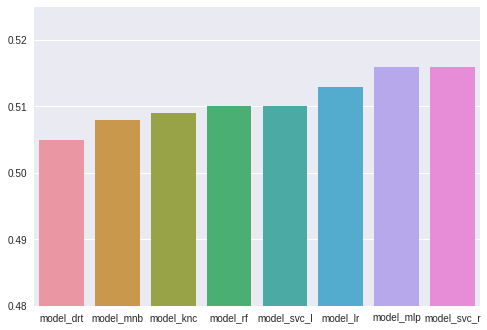

In [52]:
import seaborn as sns
X_model, Y_model = [], []
for row in sorted([(k, v.get('score')) for k, v in model_results.items()], key=lambda x: x[1]):
    x, y = row
    X_model.append(x), Y_model.append(y)
raw_data = {'X_model': X_model, 'Y_model': Y_model}
plt.ylim(0.48, 0.525)
sns.barplot(x='X_model', y='Y_model', data=raw_data)

Вывод: в этом разделе тестировали готовые модели смотрели на precision_score и time чтоб оценить эффективность модели, время учитывать также немаловажно для полного анализа эффективности.

### Аналогично для 2 ой акции

In [53]:
gazp = yf.Ticker("GAZP.ME")
gazp_hist = msft.history(period="max")

In [54]:
gazp_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.055380,0.063524,0.055380,0.060809,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060809,0.064067,0.060809,0.062980,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062980,0.064609,0.062980,0.064067,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.064067,0.064609,0.061894,0.062437,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.062437,0.062980,0.060809,0.061351,47894400,0.0,0.0


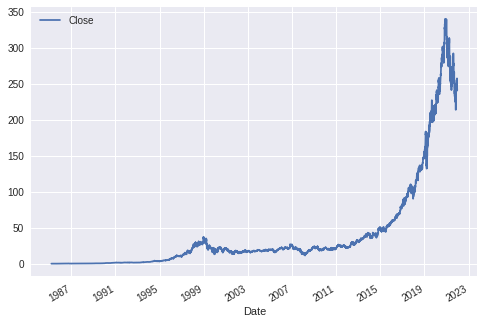

In [55]:
gazp_hist.plot.line(y='Close', use_index=True)
plt.show()

In [56]:
gazp_hist.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9270 entries, 1986-03-13 00:00:00-05:00 to 2022-12-20 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          9270 non-null   float64
 1   High          9270 non-null   float64
 2   Low           9270 non-null   float64
 3   Close         9270 non-null   float64
 4   Volume        9270 non-null   int64  
 5   Dividends     9270 non-null   float64
 6   Stock Splits  9270 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 837.4 KB


In [57]:
data = gazp_hist[['Close']]
data = data.rename(columns={'Close': 'Actual_Close'})
data.head()

,Actual_Close
Date,
1986-03-13 00:00:00-05:00,0.060809
1986-03-14 00:00:00-05:00,0.062980
1986-03-17 00:00:00-05:00,0.064067
1986-03-18 00:00:00-05:00,0.062437
1986-03-19 00:00:00-05:00,0.061351


In [58]:
data['Target'] = gazp_hist['Close'].rolling(2).apply(lambda x: x.iloc[1]>x.iloc[0])
data.head()

,Actual_Close,Target
Date,,
1986-03-13 00:00:00-05:00,0.060809,NaN
1986-03-14 00:00:00-05:00,0.062980,1.0
1986-03-17 00:00:00-05:00,0.064067,1.0
1986-03-18 00:00:00-05:00,0.062437,0.0
1986-03-19 00:00:00-05:00,0.061351,0.0


In [59]:
gazp_prev = gazp_hist.copy()
gazp_prev = gazp_prev.shift(1)
gazp_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14 00:00:00-05:00,0.055380,0.063524,0.055380,0.060809,1.031789e+09,0.0,0.0
1986-03-17 00:00:00-05:00,0.060809,0.064067,0.060809,0.062980,3.081600e+08,0.0,0.0
1986-03-18 00:00:00-05:00,0.062980,0.064609,0.062980,0.064067,1.331712e+08,0.0,0.0
1986-03-19 00:00:00-05:00,0.064067,0.064609,0.061894,0.062437,6.776640e+07,0.0,0.0


In [60]:
predictors = ["Close", "Volume", "Open", "High", "Low"]

data = data.join(gazp_prev[predictors]).iloc[1:]
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062980,1.0,0.060809,1.031789e+09,0.055380,0.063524,0.055380
1986-03-17 00:00:00-05:00,0.064067,1.0,0.062980,3.081600e+08,0.060809,0.064067,0.060809
1986-03-18 00:00:00-05:00,0.062437,0.0,0.064067,1.331712e+08,0.062980,0.064609,0.062980
1986-03-19 00:00:00-05:00,0.061351,0.0,0.062437,6.776640e+07,0.064067,0.064609,0.061894
1986-03-20 00:00:00-05:00,0.059723,0.0,0.061351,4.789440e+07,0.062437,0.062980,0.060809


In [61]:
model = RandomForestClassifier(n_estimators=100, 
                               min_samples_split=200, 
                               max_depth=5, 
                               max_features='auto',
                               min_samples_leaf=4,
                               criterion ='gini',
                               random_state=1)

In [62]:
predictors = ["Close", "Volume", "Open", "High", "Low"]


In [63]:
train = data.iloc[:-100]
test = data.iloc[-100:]

In [64]:
model.fit(train[predictors], train["Target"])

RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=200,
                       random_state=1)

In [65]:
predictors_before = ["Close", "Volume", "Open", "High", "Low"]

In [66]:
def preproc_data(msft_hist):
    data = msft_hist[['Close']]
    data = data.rename(columns={'Close': 'Actual_Close'})
    data['Target'] = msft_hist['Close'].rolling(2).apply(lambda x: x.iloc[1]>x.iloc[0])
    msft_prev = msft_hist.copy()
    msft_prev = msft_prev.shift(1)
    data = data.join(msft_prev[predictors_before]).iloc[1:]
    return data

In [67]:
def normalize_data(data, predictors):
    for el in predictors:
        mins = data[el].min()
        maxs = data[el].max()
        zn = maxs-mins
        data[el] = (data[el]-mins)/zn
    return data

In [68]:
def rolling_means(data):
    weekly_mean = data.rolling(7).mean()['Close']
    monthly_mean = data.rolling(30).mean()['Close']
    quarterly_mean = data.rolling(90).mean()['Close']
    year_mean = data.rolling(365).mean()['Close']
    
    weekly_trend = data.shift(1).rolling(7).sum()["Target"]
    monthly_trend = data.shift(1).rolling(30).sum()["Target"]
    
    # means
    data['weekly_mean'] = weekly_mean
    data['monthly_mean'] = monthly_mean
    data['quarterly_mean'] = quarterly_mean
    data['year_mean'] = year_mean
    
    #trend
    data['weekly_trend'] = weekly_trend/7
    data['monthly_trend'] = monthly_trend/31
    
     # open high low ratio
    data['open_close_ratio'] = data['Open'] / 100*data['Close']
    data['high_close_ratio'] = data['High'] /100* data['Close']
    data['low_close_ratio'] = data['Low'] / 100*data['Close']

    
    return data

In [69]:
def final_data(msft_hist):    
    data = preproc_data(msft_hist)
    data = normalize_data(data, predictors_before)
    data = rolling_means(data)
    data = data.dropna(axis=0)

    return data 

In [70]:
def backtest(data, model, predictors, start = 700, step = 350, use_predict_proba=True):
    predictions = []
    
    for i in range(start, data.shape[0], step):
        # Split into test and train
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit model
        model.fit(train[predictors], train['Target'])

        # Make predictors
        if use_predict_proba:
            preds = model.predict_proba(test[predictors])[:, 1]
            preds = pd.Series(preds, index = test.index)
            preds[preds>0.63] = 1
            preds[preds<=0.63] = 0
        else:
            preds = model.predict(test[predictors])
            preds = pd.Series(preds, index = test.index)

        # Combine predictions and test value
        combined = pd.DataFrame({'Target' :test["Target"], 'Predictions': preds})
        
        predictions.append(combined)
        
    return pd.concat(predictions)

In [71]:
def metricks(predictions):
    print(f"precision_score: {round(precision_score(predictions['Target'], predictions['Predictions']),3)}")

In [72]:
model_lr = LogisticRegression(max_iter=2000, 
                              random_state=0, 
                              penalty='l2')

In [73]:
model_knc = KNeighborsClassifier(n_neighbors=3)

In [74]:
model_rf = RandomForestClassifier(n_estimators=100, 
                                  min_samples_split=200, 
                                  max_depth=5, 
                                  max_features='auto',
                                  min_samples_leaf=4,
                                  criterion ='gini',
                                  random_state=1)

In [75]:
model_drt = DecisionTreeClassifier(random_state=42,
                                   criterion ='gini',
                                   max_depth=5,
                                   min_samples_split=5,
                                   min_samples_leaf=5,
                                   class_weight=None,)

In [76]:
model_mlp = MLPClassifier(random_state=1, max_iter=2000)

In [77]:
model_mnb = MultinomialNB()

In [78]:
model_svc_l = SVC(kernel='linear')

In [79]:
model_svc_r = SVC(kernel='rbf')

In [80]:
predictors = ['Close', 'Volume', 'Open', 'High', 'Low', 
              'weekly_mean', 'monthly_mean', 'quarterly_mean', 'year_mean', 'weekly_trend', 'monthly_trend', 
              'open_close_ratio', 'high_close_ratio', 'low_close_ratio'
             ]
              

In [81]:
%%time
# model_lr
data = final_data(msft_hist)
predictions = backtest(data, model_lr, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.518
CPU times: user 2.06 s, sys: 917 ms, total: 2.98 s
Wall time: 2.01 s


In [82]:
%%time
# model_knc
data = final_data(msft_hist)
predictions = backtest(data, model_knc, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.509
CPU times: user 1.49 s, sys: 80.3 ms, total: 1.57 s
Wall time: 1.51 s


In [83]:
%%time
# model_rf
data = final_data(msft_hist)
predictions = backtest(data, model_rf, predictors, use_predict_proba=False)
metricks(predictions)

precision_score: 0.51
CPU times: user 17.1 s, sys: 52.8 ms, total: 17.2 s
Wall time: 17.2 s


In [84]:
%%time
data = final_data(msft_hist)
predictions = backtest(data, model_rf, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.589
CPU times: user 17 s, sys: 49 ms, total: 17.1 s
Wall time: 17.1 s


In [85]:
predictions['Predictions'].value_counts()

0.0    8064
1.0     141
Name: Predictions, dtype: int64

In [86]:
%%time
# model_drt
data = final_data(msft_hist)
predictions = backtest(data, model_drt, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.521
CPU times: user 2 s, sys: 6.76 ms, total: 2.01 s
Wall time: 2.01 s


In [87]:
%%time
# model_mlp
data = final_data(msft_hist)
predictions = backtest(data, model_mlp, predictors, use_predict_proba=True)
metricks(predictions)

precision_score: 0.552
CPU times: user 15.6 s, sys: 11.9 s, total: 27.5 s
Wall time: 16.2 s


In [88]:
import time

In [89]:
%%time
# model_mnb
data = final_data(msft_hist)
predictions = backtest(data, model_mnb, predictors, use_predict_proba=False)
metricks(predictions)

precision_score: 0.508
CPU times: user 1.03 s, sys: 69.8 ms, total: 1.1 s
Wall time: 1.03 s


In [90]:
%%time
# model_svc_l
data = final_data(msft_hist)
predictions = backtest(data, model_svc_l, predictors, use_predict_proba=False)
metricks(predictions)

precision_score: 0.51
CPU times: user 27.2 s, sys: 292 ms, total: 27.5 s
Wall time: 27.4 s


In [91]:
%%time
# model_svc_r
data = final_data(msft_hist)
predictions = backtest(data, model_svc_r, predictors, use_predict_proba=False)
metricks(predictions)

precision_score: 0.516
CPU times: user 45.7 s, sys: 345 ms, total: 46.1 s
Wall time: 46 s


In [92]:
def model_learning(gazp_hist, model_type, predictors, use_predict_proba=False):
    
    data = final_data(gazp_hist)
    predictions = backtest(data, model_type, predictors, use_predict_proba=False)
    return {
        'model': model_type, 
        'score': round(precision_score(predictions['Target'], predictions['Predictions']), 3)
    }

model_types = {
    'model_lr': model_lr, 'model_knc': model_knc, 'model_rf': model_rf,
    'model_drt': model_drt, 'model_mlp': model_mlp, 'model_mnb': model_mnb,
    'model_svc_l': model_svc_l, 'model_svc_r': model_svc_r
}
model_results = {}
gazp_hist = gazp.history(period="max")

for model_name, model_type in model_types.items():
    data = final_data(gazp_hist.copy())
    model_results[model_name] = model_learning(gazp_hist, model_type, predictors)

model_results

{'model_lr': {'model': LogisticRegression(max_iter=2000, random_state=0),
  'score': 0.545},
 'model_knc': {'model': KNeighborsClassifier(n_neighbors=3), 'score': 0.543},
 'model_rf': {'model': RandomForestClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=200,
                         random_state=1), 'score': 0.524},
 'model_drt': {'model': DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=5,
                         random_state=42), 'score': 0.527},
 'model_mlp': {'model': MLPClassifier(max_iter=2000, random_state=1),
  'score': 0.537},
 'model_mnb': {'model': MultinomialNB(), 'score': 0.535},
 'model_svc_l': {'model': SVC(kernel='linear'), 'score': 0.535},
 'model_svc_r': {'model': SVC(), 'score': 0.517}}

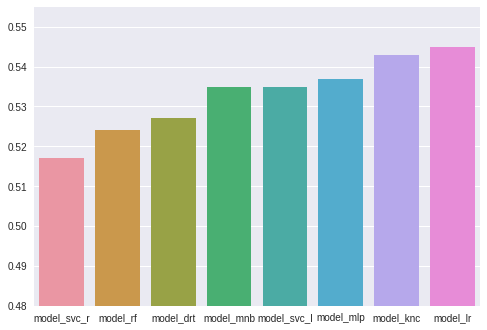

In [93]:
import seaborn as sns
X_model, Y_model = [], []
for row in sorted([(k, v.get('score')) for k, v in model_results.items()], key=lambda x: x[1]):
    x, y = row
    X_model.append(x), Y_model.append(y)
raw_data = {'X_model': X_model, 'Y_model': Y_model}
plt.ylim(0.48, 0.555)
sns.barplot(x='X_model', y='Y_model', data=raw_data)

Повторили весь алгоритм для акции российского фондового рынка

### Заключение

In [ ]:
predictors = ["Close", "Volume", "Open", "High", "Low"]

data = data.join(msft_prev[predictors]).iloc[1:]
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14 00:00:00-05:00,0.062980,1.0,0.060809,1.031789e+09,0.055380,0.063524,0.055380
1986-03-17 00:00:00-05:00,0.064067,1.0,0.062980,3.081600e+08,0.060809,0.064067,0.060809
1986-03-18 00:00:00-05:00,0.062437,0.0,0.064067,1.331712e+08,0.062980,0.064609,0.062980
1986-03-19 00:00:00-05:00,0.061351,0.0,0.062437,6.776640e+07,0.064067,0.064609,0.061894
1986-03-20 00:00:00-05:00,0.059723,0.0,0.061351,4.789440e+07,0.062437,0.062980,0.060809


In [ ]:
sum(data['Target']==1)/len(data['Target'])

0.4943988050784167

В ходе выполнения данной курсовой работы был создан инструмент по предсказанию роста цены акции, основанный на методах машинного обучения с учителем, а также на методах и приемах подготовительного и описательного анализа данных. Инструмент не идеален, и открыт к дальнейшим усовершенствованиям. Также стоит упоминуть о балансе класснов, для этого обратимся к когду выше, как мы видим соотношение 1 и 0 в Target приблизительно 50/50. Более того данный инструмент дает небольшое конкурентное преимущество на фондовом рынке, однако необходимо отметить, что хоть данный интсрумент показывает эффективность выше, чем при покупке наугад. Ведь покупая наугад мы фактически играем в 'Орел или Решка', но тем не менее машинное обучение не так хорошо работает для предсказания цены акции, ведь если бы оно могло угадывать рост или падение акции с высокой вероятностью, то проигравших на фондовом рынке не было бы, именно поэтому данный инструмент открыт для дальнейшего усовершенствования. 